# Sprint 2 - Notebook 4 - Time Series Analysis
### Hugo C Marrochio
### Date: Nov 24 2024

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import matplotlib.dates as mdates


from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity

import seaborn as sns
import plotly.graph_objects as go
import random
plt.rcParams['figure.figsize'] = (8.0, 6.0) #setting figure size

from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError



from sklearn.metrics import mean_squared_error

In [2]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam

In [3]:
from EDA_auxiliary_functions2 import *

In [43]:
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()

## Summary of Sprint 2 Time Series - Notebook 4

In this notebook, I will continue the modelling of S&P500 data from kaggle (https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks). We change gears on this notebook and explore time series prediction techniques with machine learning. At least for now, the metric I am using to evaluate this models is the Mean Squared Error, comparing predictions to test data. For simplicity, I will focus on anaylzing just $1$ stock over a period of time, in order to test which models and techniques seem more promising. At this point in the project, the results obtained are:

| Model       |  Parameters           | MSE        |
|:-----------:|:---------------------:|:----------:| 
| Naive Avg   | Training Data Average |    0.356   |  
| ARIMA       |       (40,2,30)       |   0.202    |
| RNN*        | ReLU, avoid overfitting |   0.208  |



And for the neural network models (will update once run more experiments)



| Model       |  Learning Rate (ADAM) | Activation | MSE        |
|:-----------:|:---------------------:|:----------:|:----------:|   
| RNN         |            0.005      |     'ReLU' |    0.028   |
| GRU         |                       |            |            |
| LSTM        |                       |            |            |
| Transformer |                       |            |            |

The difference between RNN and RNN* is not the model itself, it is exactly the same training and weights, but it is the __forecasting__. For RNN*, we procude all the test data having access to only the training data. For RNN, we only predict the next step on the training data, so using the information up to that particular step. Notice however that there is no retraining, the model is still the same. I want to explore more the forecasting subtleties for my next Sprint.


### Notebook 4

#### 0 - Loading Auxiliary Functions and csv Files

    - Load the data we produced in Notebook 1.
    - Import auxiliary functions.

#### Part 8 - Time Series Data Preprocessing

    - Here we isolate the data into a training period of 2 years and a test period of 4 months.
    - We study two different predictions in this notebook: `Log-Return` and `Adj Close` (adjusted price).
    

#### Part 9 - Time Series Analysis: Simple Naive Forecasting and ARIMA

    - First, we study forecasting for a simple naive problem of predicting the average of the training data.
    - Next, we evaluate an ARIMA model, doing a small hyperparameter search to optimize Mean Squared Error for the test data.
    - I want to investigate further how to incorporate rolling window approach to this ARIMA model for next Sprint.

#### Part 10 - Recurrent Neural Networks
    - We generate a rolling window of 40 data points in order to train the RNN. 
    - We experiment with a few simple RNN hyperparameters, but I still want to investigate more learning rate.
    - The conclusion so far is that for predicting price, the RNN is outperforming the other models analyzed, but only if we forecast to the next day.
    - If we only use the training data for the full forecast into 4 months into the future, the RNN is performing similarly to the ARIMA model.

#### Part 11 - Next Steps and Models
    - We discuss briefly what are the next steps in order to conlude this forecasting notebook.


#### Appendix - Naive Forecasting - Access to Data Every Day in the Test Set
    - In this appendix, we simply forecast the previous day price to the next one.
    - This means that if we actually only need to predict one day into the future, this naive approach performs really well in the testing data. It only shows that complex models should really be used only dependent on the goals of the problem studied.

# 0. Import data set

In [4]:
df_top_100=pd.read_csv('data/sp500_stocks_top_100.csv')
df_top_60=pd.read_csv('data/sp500_stocks_top_60.csv')
df_top_30=pd.read_csv('data/sp500_stocks_top_30.csv')
df_random_100=pd.read_csv('data/sp500_stocks_random_100.csv')
df_random_60=pd.read_csv('data/sp500_stocks_random_60.csv')
df_random_30=pd.read_csv('data/sp500_stocks_random_30.csv')

In [5]:
#Transform the date column into datetime object
df_top_100['Date']=pd.to_datetime(df_top_100['Date'])
df_top_60['Date']=pd.to_datetime(df_top_60['Date'])
df_top_30['Date']=pd.to_datetime(df_top_30['Date'])
df_random_100['Date']=pd.to_datetime(df_random_100['Date'])
df_random_60['Date']=pd.to_datetime(df_random_60['Date'])
df_random_30['Date']=pd.to_datetime(df_random_30['Date'])

In [6]:
df_companies=pd.read_csv('data/sp500_companies.csv')
df_top100_cluster=pd.read_csv('data/top100_cluster.csv')

## Part 8 - Data preprocessing

### 8.1 Data pre-processing: Log-Return

In this notebook, we focus on time series analysis for 1 stock over a period of time. As a first test, we will divide the data into __2 years__ of training data and __4 months__ of testing data. 

In [7]:
condition_2y=(df_top_30['Date']>'2015-01-01')&(df_top_30['Date']<'2016-12-31')
condition_4m=(df_top_30['Date']>'2016-12-31')&(df_top_30['Date']<'2017-04-30')

df_top_30_2y=df_top_30[condition_2y]
df_top_30_4m=df_top_30[condition_4m]

As an example, we will focus on forecasting of Apple stock, and `Log_Return` as the predictor for now. Later in the section, we will also directly use `Adj Close`, which is the adjusted price as a predictor.

In [8]:
#Create the training data
df_Apple_train=df_top_30_2y[df_top_30_2y['Symbol']=='AAPL'][['Date','Log_Return']].reset_index()
df_Apple_train.drop('index', axis=1, inplace=True)

In [9]:
df_Apple_train.head()

,Date,Log_Return
0,2015-01-02,-0.009558
1,2015-01-05,-0.028576
2,2015-01-06,0.000094
3,2015-01-07,0.013925
4,2015-01-08,0.037702


In [10]:
#Create the testing data
df_Apple_test=df_top_30_4m[df_top_30_4m['Symbol']=='AAPL'][['Date','Log_Return']].reset_index()
df_Apple_test.drop('index', axis=1, inplace=True)

In [11]:
df_Apple_test.head()

,Date,Log_Return
0,2017-01-03,0.002845
1,2017-01-04,-0.001120
2,2017-01-05,0.005073
3,2017-01-06,0.011087
4,2017-01-09,0.009118


It is useful to plot both training and test data, also in order to confirm we split it correctly.

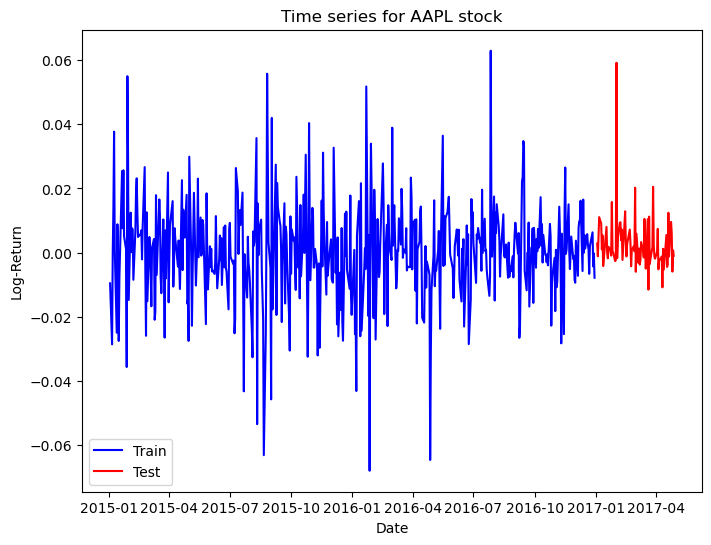

In [12]:
plt.plot(df_Apple_train['Date'],df_Apple_train['Log_Return'],color='blue',label='Train')
plt.plot(df_Apple_test['Date'],df_Apple_test['Log_Return'],color='red',label='Test')
plt.xlabel('Date')
plt.ylabel('Log-Return')
plt.title('Time series for AAPL stock')
plt.legend()
plt.show()

Also, it will be useful to define a DataFrame for the time period consisting of both training and test data

In [13]:
condition_joined=(df_top_30['Date']>'2015-01-01')&(df_top_30['Date']<'2017-04-30')
df_top_30_joined=df_top_30[condition_joined]
df_Apple_joined=df_top_30_joined[df_top_30_joined['Symbol']=='AAPL'][['Date','Log_Return']].reset_index()
df_Apple_joined.drop('index', axis=1, inplace=True)

Next, let us manipulate the dataframe in order to create numpy arrays, which will be useful once we have to model the RNN.

In [14]:
# Cast the 'Log_Return' values to an array
array_train = df_Apple_train['Log_Return'].values 
# Reshape
array_train = np.reshape(array_train, (-1,1)) 
array_train.shape

(504, 1)

Since Neural Networks are somewhat sensitive to scaling, we will create a scaled data fit for the training data

In [15]:
# fit scaler only on the train data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_array_train = scaler.fit_transform(array_train)

Same for the test data, but notice that we do __not__ fit again, we only __transform__.

In [16]:
array_test = df_Apple_test['Log_Return'].values 
array_test = np.reshape(array_test, (-1,1)) 
scaled_array_test = scaler.transform(array_test)

Let us plot again for the scaled data in order to check consistency

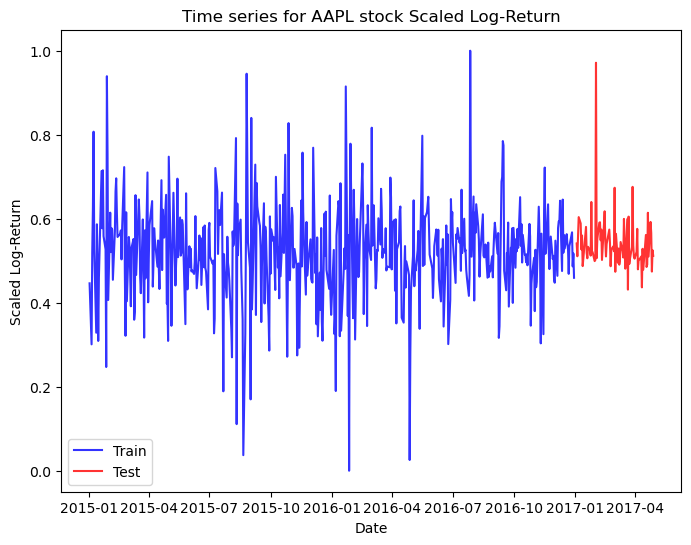

In [17]:
plt.plot(df_Apple_train['Date'],scaled_array_train[:,0],alpha=0.8,color='blue',label='Train')
plt.plot(df_Apple_test['Date'],scaled_array_test[:,0],alpha=0.8,color='red',label='Test')
plt.xlabel('Date')
plt.ylabel('Scaled Log-Return')
plt.title('Time series for AAPL stock Scaled Log-Return')
plt.legend()
plt.show()

### 8.2 Data pre-processing: Prices

In this section, we will repeat the preprocessing, but considering `Adj Close` (price) instead of `Log-Return`. 

In [18]:
df_Apple_train_p=df_top_30_2y[df_top_30_2y['Symbol']=='AAPL'][['Date','Adj Close']].reset_index()
df_Apple_train_p.drop('index', axis=1, inplace=True)

In [19]:
df_Apple_train_p.head()

,Date,Adj Close
0,2015-01-02,24.373964
1,2015-01-05,23.687304
2,2015-01-06,23.689537
3,2015-01-07,24.021717
4,2015-01-08,24.944685


In [20]:
df_Apple_test_p=df_top_30_4m[df_top_30_4m['Symbol']=='AAPL'][['Date','Adj Close']].reset_index()
df_Apple_test_p.drop('index', axis=1, inplace=True)

In [21]:
df_Apple_test_p.head()

,Date,Adj Close
0,2017-01-03,26.921547
1,2017-01-04,26.891411
2,2017-01-05,27.028166
3,2017-01-06,27.329483
4,2017-01-09,27.579803


Let us plot the price for training and test data.

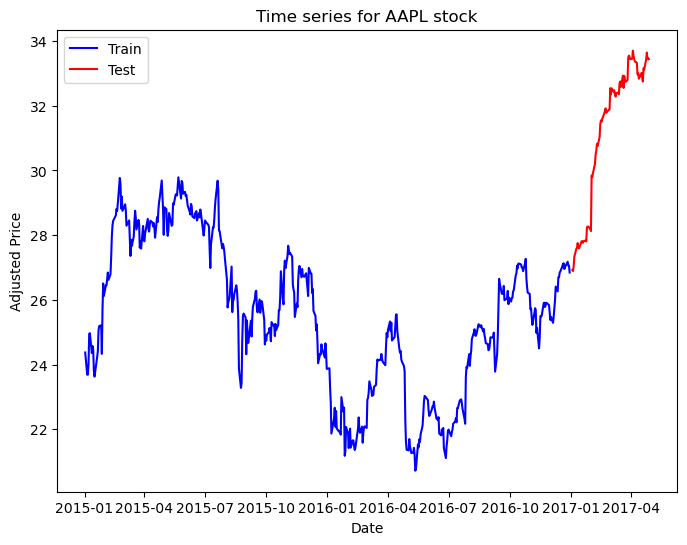

In [22]:
plt.plot(df_Apple_train_p['Date'],df_Apple_train_p['Adj Close'],color='blue',label='Train')
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],color='red',label='Test')
plt.xlabel('Date')
plt.ylabel('Adjusted Price')
plt.title('Time series for AAPL stock')
plt.legend()
plt.show()

As before, let us copy the price values to an array

In [23]:
array_train_p = df_Apple_train_p['Adj Close'].values 
# Reshaping 
array_train_p = np.reshape(array_train_p, (-1,1)) 

Once again, it is important to rescale for the RNN algorithms we will analyze, but we only fit the scaler to the __training__ data.

In [24]:
# fit scaler only on the train data
scaler_p = MinMaxScaler(feature_range=(0,1))
scaled_array_train_p = scaler_p.fit_transform(array_train_p)

Same for the test data, we only transform with the scaler

In [25]:
array_test_p = df_Apple_test_p['Adj Close'].values 
array_test_p = np.reshape(array_test_p, (-1,1)) 
scaled_array_test_p = scaler_p.transform(array_test_p)

For sanity check, let us plot both training and test data

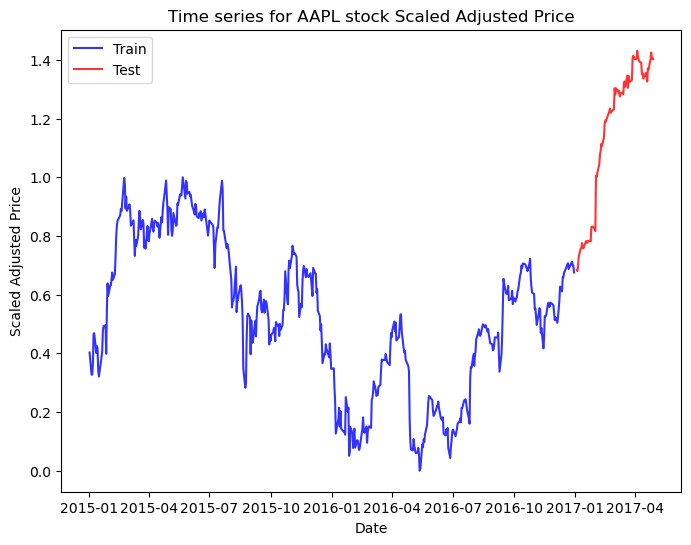

In [26]:
plt.plot(df_Apple_train_p['Date'],scaled_array_train_p[:,0],alpha=0.8,color='blue',label='Train')
plt.plot(df_Apple_test_p['Date'],scaled_array_test_p[:,0],alpha=0.8,color='red',label='Test')
plt.xlabel('Date')
plt.ylabel('Scaled Adjusted Price')
plt.title('Time series for AAPL stock Scaled Adjusted Price')
plt.legend()
plt.show()

As before, it is useful to join both train and test in one DataFrame

In [27]:
df_Apple_joined_p=df_top_30_joined[df_top_30_joined['Symbol']=='AAPL'][['Date','Adj Close']].reset_index()
df_Apple_joined_p.drop('index', axis=1, inplace=True)

We are ready to start out forecasting analysis!

## Part 9 - Time Series Analysis: Simple Naive Forecasting and ARIMA

### 9.1 Baseline - Simple Naive Forecasting

#### Log-Return Naive Forecasting

The first forecasting technique we will try is a simple guess that the future values is the mean of the training data. This is a simple model with the idea to benchmark what advantages the more complicated models have. In appendix A, I will discuss another naive forecasting method of using the previous day as the future value, but since it needs to be updated daily, I am using simply the average of the training data for comparison.

In [529]:
df_Apple_joined['Naive_Forecast_avg']=df_Apple_joined['Log_Return'].mean()

Let us cast the naive forecast to a separate dataframe

In [530]:
df_Apple_NaiveForecast_avg=df_Apple_joined[['Date','Naive_Forecast_avg']]

We need to do scaling in order to compare the mean squared errors to the other methods we will employ

In [533]:
array_naive_avg = df_Apple_NaiveForecast_avg['Naive_Forecast_avg'].values 
array_naive_avg = np.reshape(array_naive_avg, (-1,1)) 
scaled_array_naive_avg = scaler.transform(array_naive_avg)

In [534]:
df_Apple_NaiveForecast_avg['Scaled_Naive_Forecast']=scaled_array_naive_avg

/var/folders/qr/7jt362956klf0dnc_163b7nw0000gp/T/ipykernel_66814/3984864862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Apple_NaiveForecast_avg['Scaled_Naive_Forecast']=scaled_array_naive_avg


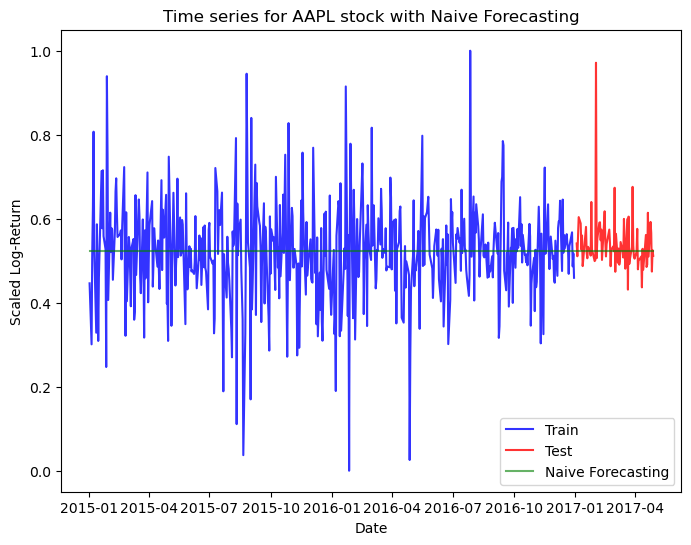

In [536]:
plt.plot(df_Apple_train['Date'],scaled_array_train[:,0],alpha=0.8,color='blue',label='Train')
plt.plot(df_Apple_test['Date'],scaled_array_test[:,0],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_NaiveForecast_avg['Date'],df_Apple_NaiveForecast_avg['Scaled_Naive_Forecast'],color='green',alpha=0.6,label='Naive Forecasting')
plt.xlabel('Date')
plt.ylabel('Scaled Log-Return')
plt.title('Time series for AAPL stock with Naive Forecasting')
plt.legend()
plt.show()

Let us look into the two losses

In [86]:
mse = tf.keras.losses.MeanSquaredError()

In [537]:
mse(scaled_array_test[:,0],df_Apple_NaiveForecast_avg[df_Apple_NaiveForecast_avg['Date'].isin(df_Apple_test['Date'])]['Scaled_Naive_Forecast'].values).numpy()

0.004790286043627638

In [90]:
mae = tf.keras.losses.MeanAbsoluteError()

In [538]:
mae(scaled_array_test[:,0],df_Apple_NaiveForecast[df_Apple_NaiveForecast['Date'].isin(df_Apple_test['Date'])]['Scaled_Naive_Forecast'].values).numpy()

0.0660669706104712

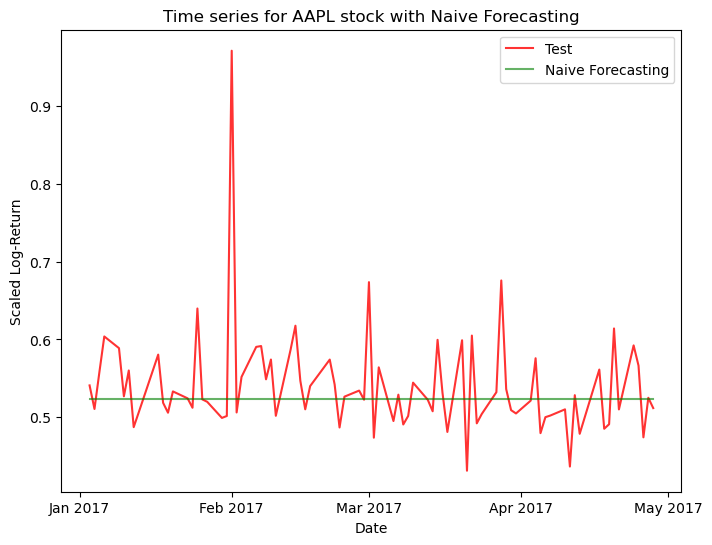

In [539]:
plt.plot(df_Apple_test['Date'],scaled_array_test[:,0],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_test['Date'],df_Apple_NaiveForecast_avg[df_Apple_NaiveForecast_avg['Date'].isin(df_Apple_test['Date'])]['Scaled_Naive_Forecast'].values,color='green',alpha=0.6,label='Naive Forecasting')
plt.xlabel('Date')
plt.ylabel('Scaled Log-Return')
plt.title('Time series for AAPL stock with Naive Forecasting')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.show()

#### Price Naive Forecasting

We repeat the naive forecasting of the average of the training data for Prices.

In [541]:
df_Apple_joined_p['Naive_Forecast']=df_Apple_joined_p['Adj Close'].mean()

Let us cast the naive forecast to a separate dataframe

In [542]:
df_Apple_NaiveForecast_avg_p=df_Apple_joined_p[['Date','Naive_Forecast']]

Let us do the scaling in order to compare the mean squared errors to the other methods we will employ

In [543]:
array_naive_avg_p = df_Apple_NaiveForecast_avg_p['Naive_Forecast'].values 
array_naive_avg_p = np.reshape(array_naive_avg_p, (-1,1)) 
scaled_array_naive_avg_p = scaler_p.transform(array_naive_avg_p)

In [544]:
df_Apple_NaiveForecast_avg_p['Scaled_Naive_Forecast']=scaled_array_naive_avg_p

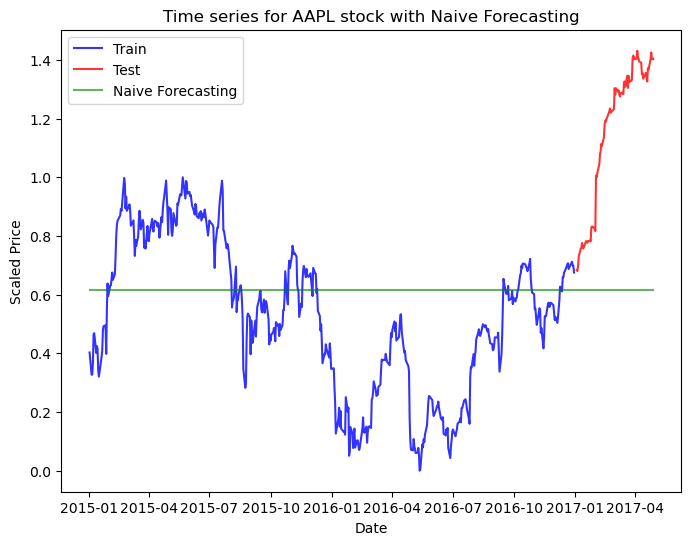

In [579]:
plt.plot(df_Apple_train['Date'],scaled_array_train_p[:,0],alpha=0.8,color='blue',label='Train')
plt.plot(df_Apple_test['Date'],scaled_array_test_p[:,0],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_NaiveForecast_avg_p['Date'],df_Apple_NaiveForecast_avg_p['Scaled_Naive_Forecast'],color='green',alpha=0.6,label='Naive Forecasting')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.title('Time series for AAPL stock with Naive Forecasting')
plt.savefig('figures/naive_avg.png')
plt.legend()
plt.show()

Let us look into the two losses

In [546]:
scaled_array_naiveforecast_test_avg_p=df_Apple_NaiveForecast_avg_p[df_Apple_NaiveForecast_avg_p['Date'].isin(df_Apple_test_p['Date'])]['Scaled_Naive_Forecast'].values

In [548]:
mse = tf.keras.losses.MeanSquaredError()

In [549]:
mse(scaled_array_test_p[:,0],scaled_array_naiveforecast_test_avg_p).numpy()

0.35567331790523277

In [90]:
mae = tf.keras.losses.MeanAbsoluteError()

In [550]:
mae(scaled_array_test_p[:,0],scaled_array_naiveforecast_test_avg_p).numpy()

0.5441495875479989

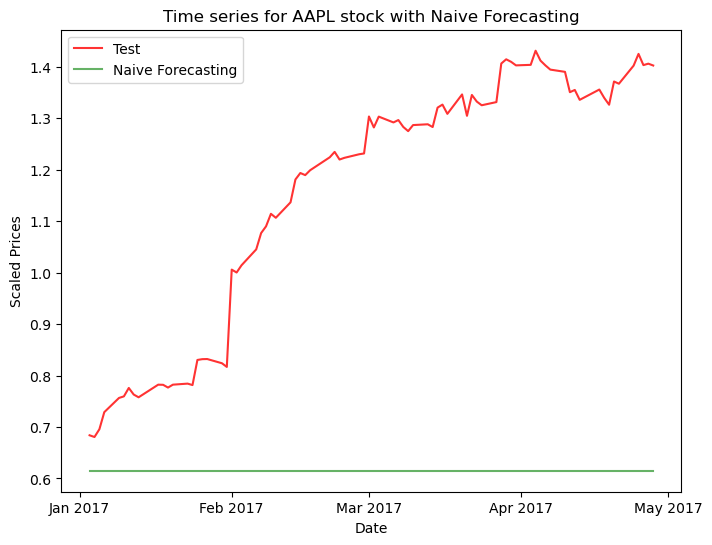

In [551]:
plt.plot(df_Apple_test['Date'],scaled_array_test_p[:,0],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_test['Date'],scaled_array_naiveforecast_test_avg_p,color='green',alpha=0.6,label='Naive Forecasting')
plt.xlabel('Date')
plt.ylabel('Scaled Prices')
plt.title('Time series for AAPL stock with Naive Forecasting')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.show()

The naive forecasting for prices definitely underperforms, as we will see in the next sections.

### 9.2 ARIMA

#### Log-Return ARIMA

Let us do a simple search for hyperparameters to use in our ARIMA prediction. Once we have selected hyperparameters, we will analyze it a bit more closely.

For these parameters it took long to run, 19 minutes!

In [154]:
p_list=[2,6,10,14,24,28,32,36]
q_list=[2,6,10,14,24,28,32,36]
matrix_score=np.zeros((len(p_list),len(q_list)))

In [155]:
%%time
for id_p,p in enumerate(p_list):
    for id_q,q in enumerate(p_list):
        model2 = SARIMAX(scaled_array_train[:,0], order=(p, 1, q), trend="c")
        model_fit2 = model2.fit(disp=0)
        train_predictions2 = model_fit2.predict(start=0, end=len(df_Apple_train['Log_Return'])-1)
        test_predictions2 = model_fit2.predict(start=len(df_Apple_train['Log_Return']), end=len(df_Apple_train['Log_Return'])+len(df_Apple_test['Log_Return'])-1)
        # Calculate MSE for training data
        train_mse2 = mean_squared_error(scaled_array_train, train_predictions2)
        train_rmse2 = np.sqrt(train_mse2)

        # Calculate MSE for testing data
        test_mse2 = mean_squared_error(scaled_array_test, test_predictions2)
        test_rmse2 = np.sqrt(test_mse2)

        print(f"q={q},p={p}, Train MSE: {train_mse2}, RMSE: {train_rmse2}")
        print(f"q={q},p={p}, Test MSE: {test_mse2}, RMSE: {test_rmse2}")
        matrix_score[id_p,id_q]=test_rmse2

/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=2,p=2, Train MSE: 0.015144370018238682, RMSE: 0.12306246388821687
q=2,p=2, Test MSE: 0.004852471051306374, RMSE: 0.06965968024120103


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=6,p=2, Train MSE: 0.015136038954494856, RMSE: 0.12302861030871988
q=6,p=2, Test MSE: 0.0047878333190716936, RMSE: 0.0691941711350869


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=10,p=2, Train MSE: 0.015039062815641956, RMSE: 0.12263385672660693
q=10,p=2, Test MSE: 0.0047439424226982715, RMSE: 0.06887628345590571
q=14,p=2, Train MSE: 0.014859652825895263, RMSE: 0.1219001756598212
q=14,p=2, Test MSE: 0.004870511169258705, RMSE: 0.06978904763111977


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=24,p=2, Train MSE: 0.014714992999433671, RMSE: 0.12130537085980023
q=24,p=2, Test MSE: 0.00470216183589479, RMSE: 0.06857231100010258


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=28,p=2, Train MSE: 0.014684842037416617, RMSE: 0.12118103002292321
q=28,p=2, Test MSE: 0.004731737076044079, RMSE: 0.06878762298585465


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=32,p=2, Train MSE: 0.014459039982984024, RMSE: 0.12024574829483171
q=32,p=2, Test MSE: 0.004902038070252953, RMSE: 0.07001455613122855


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=36,p=2, Train MSE: 0.014590777918232092, RMSE: 0.12079229246202794
q=36,p=2, Test MSE: 0.00515939607450266, RMSE: 0.07182893619219667


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=2,p=6, Train MSE: 0.015064592158759679, RMSE: 0.12273790025399521
q=2,p=6, Test MSE: 0.004777628564833779, RMSE: 0.06912039181626345


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


q=6,p=6, Train MSE: 0.015050357466507711, RMSE: 0.12267989837992087
q=6,p=6, Test MSE: 0.004739760725315931, RMSE: 0.0688459201791648


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=10,p=6, Train MSE: 0.01500686995480636, RMSE: 0.12250253040164664
q=10,p=6, Test MSE: 0.004766490474473269, RMSE: 0.06903977458301315


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=14,p=6, Train MSE: 0.014878325556144437, RMSE: 0.12197674186558861
q=14,p=6, Test MSE: 0.004761615533123612, RMSE: 0.06900446024079612


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=24,p=6, Train MSE: 0.014724693419533237, RMSE: 0.12134534774573452
q=24,p=6, Test MSE: 0.004680380081229159, RMSE: 0.06841330339363215


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=28,p=6, Train MSE: 0.014574465997444016, RMSE: 0.12072475304362405
q=28,p=6, Test MSE: 0.004852478542633321, RMSE: 0.06965973401207702


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=32,p=6, Train MSE: 0.014430070758413219, RMSE: 0.12012522948329056
q=32,p=6, Test MSE: 0.0048042459174013445, RMSE: 0.06931266779890487


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=36,p=6, Train MSE: 0.014376558505572819, RMSE: 0.11990228732419085
q=36,p=6, Test MSE: 0.005061698938308021, RMSE: 0.07114561784332202


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zero

q=2,p=10, Train MSE: 0.015020679934581069, RMSE: 0.12255888354003992
q=2,p=10, Test MSE: 0.004835822708560813, RMSE: 0.06954007987168848


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


q=6,p=10, Train MSE: 0.014956739185100097, RMSE: 0.12229774807861385
q=6,p=10, Test MSE: 0.004800015962188663, RMSE: 0.06928214749983334


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=10,p=10, Train MSE: 0.014959010329981266, RMSE: 0.12230703303564054
q=10,p=10, Test MSE: 0.004810098912650157, RMSE: 0.06935487663207367


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=14,p=10, Train MSE: 0.014883553243616208, RMSE: 0.12199816901747422
q=14,p=10, Test MSE: 0.004774789793639141, RMSE: 0.06909985378884055


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=24,p=10, Train MSE: 0.01451209715636256, RMSE: 0.12046616602333853
q=24,p=10, Test MSE: 0.004676618408356711, RMSE: 0.06838580560581788


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=28,p=10, Train MSE: 0.014504626293047293, RMSE: 0.12043515389223901
q=28,p=10, Test MSE: 0.004899070168132419, RMSE: 0.06999335802869025


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=32,p=10, Train MSE: 0.014394847520408574, RMSE: 0.11997852941426052
q=32,p=10, Test MSE: 0.00485707245953226, RMSE: 0.06969270018827123


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=36,p=10, Train MSE: 0.014355022760559534, RMSE: 0.11981244827045115
q=36,p=10, Test MSE: 0.004973556144430907, RMSE: 0.07052344393484274


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zero

q=2,p=14, Train MSE: 0.015108010631617064, RMSE: 0.12291464775044944
q=2,p=14, Test MSE: 0.004730166393420797, RMSE: 0.06877620513971963


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


q=6,p=14, Train MSE: 0.014939749161768783, RMSE: 0.122228266623432
q=6,p=14, Test MSE: 0.004793075392959182, RMSE: 0.06923204021953407


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


q=10,p=14, Train MSE: 0.014955884792765224, RMSE: 0.12229425494586908
q=10,p=14, Test MSE: 0.004778941078818987, RMSE: 0.06912988556926003


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


q=14,p=14, Train MSE: 0.014863912419909841, RMSE: 0.12191764605630245
q=14,p=14, Test MSE: 0.004857471133720495, RMSE: 0.06969556035875238


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=24,p=14, Train MSE: 0.014627238981007248, RMSE: 0.12094312291737488
q=24,p=14, Test MSE: 0.004830066433867932, RMSE: 0.06949867936779758


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=28,p=14, Train MSE: 0.014610710878745818, RMSE: 0.12087477354165267
q=28,p=14, Test MSE: 0.004771022071940191, RMSE: 0.06907258553102086


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=32,p=14, Train MSE: 0.014438154312642552, RMSE: 0.12015887113585311
q=32,p=14, Test MSE: 0.004898942200961714, RMSE: 0.06999244388476313


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=36,p=14, Train MSE: 0.014266916960895173, RMSE: 0.11944420019781275
q=36,p=14, Test MSE: 0.005078582365048547, RMSE: 0.07126417308191085


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=2,p=24, Train MSE: 0.014867179701116022, RMSE: 0.12193104486190555
q=2,p=24, Test MSE: 0.004566478481620249, RMSE: 0.06757572405546425


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=6,p=24, Train MSE: 0.014744216396677022, RMSE: 0.12142576496228888
q=6,p=24, Test MSE: 0.004720030628900148, RMSE: 0.06870247905934798


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=10,p=24, Train MSE: 0.014671481444455799, RMSE: 0.12112589089231005
q=10,p=24, Test MSE: 0.0047059880004508186, RMSE: 0.06860020408461492


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=14,p=24, Train MSE: 0.014619966427001852, RMSE: 0.12091305317045738
q=14,p=24, Test MSE: 0.004783892358999298, RMSE: 0.06916568772881028


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=24,p=24, Train MSE: 0.014617171051506452, RMSE: 0.12090149317318812
q=24,p=24, Test MSE: 0.004763556387778084, RMSE: 0.06901852206312509


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=28,p=24, Train MSE: 0.014531001150447111, RMSE: 0.12054460232813044
q=28,p=24, Test MSE: 0.004820674147977415, RMSE: 0.0694310748006785


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=32,p=24, Train MSE: 0.014446308136690662, RMSE: 0.12019279569379632
q=32,p=24, Test MSE: 0.00475365282304072, RMSE: 0.06894673903123134


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=36,p=24, Train MSE: 0.01378281767877747, RMSE: 0.11740024565041365
q=36,p=24, Test MSE: 0.005704245098312556, RMSE: 0.07552645297054904


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=2,p=28, Train MSE: 0.014840760873439825, RMSE: 0.12182266157591462
q=2,p=28, Test MSE: 0.004647640347819624, RMSE: 0.0681736044801771


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=6,p=28, Train MSE: 0.014698462437902807, RMSE: 0.12123721556478773
q=6,p=28, Test MSE: 0.004738665916223065, RMSE: 0.06883796856548764


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=10,p=28, Train MSE: 0.014631599358940211, RMSE: 0.1209611481383184
q=10,p=28, Test MSE: 0.004725159643809281, RMSE: 0.06873979665237075


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=14,p=28, Train MSE: 0.014625347507336866, RMSE: 0.12093530298195339
q=14,p=28, Test MSE: 0.004756226721325526, RMSE: 0.06896540235020401


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=24,p=28, Train MSE: 0.014526674730988152, RMSE: 0.1205266556865665
q=24,p=28, Test MSE: 0.00487105881718219, RMSE: 0.06979297111588094


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=28,p=28, Train MSE: 0.014558673452754117, RMSE: 0.12065932808015349
q=28,p=28, Test MSE: 0.004814602729061202, RMSE: 0.06938733839153367


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=32,p=28, Train MSE: 0.014437541741483463, RMSE: 0.12015632210368068
q=32,p=28, Test MSE: 0.004910489926665793, RMSE: 0.0700748879889636


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=36,p=28, Train MSE: 0.01384228789121832, RMSE: 0.11765325278639056
q=36,p=28, Test MSE: 0.0048080392901524455, RMSE: 0.06934002660911262


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=2,p=32, Train MSE: 0.014646583434330908, RMSE: 0.1210230698434431
q=2,p=32, Test MSE: 0.004961887097319703, RMSE: 0.07044066366325422


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=6,p=32, Train MSE: 0.014508788328020657, RMSE: 0.12045243180617259
q=6,p=32, Test MSE: 0.004818436457855393, RMSE: 0.06941495845893299


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=10,p=32, Train MSE: 0.014563037467411041, RMSE: 0.1206774107586463
q=10,p=32, Test MSE: 0.004748179697456047, RMSE: 0.06890703663237918


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=14,p=32, Train MSE: 0.014481642373160634, RMSE: 0.12033969574982577
q=14,p=32, Test MSE: 0.004756901699892714, RMSE: 0.06897029577936226


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=24,p=32, Train MSE: 0.014471767773853474, RMSE: 0.12029866073175326
q=24,p=32, Test MSE: 0.004766570278687725, RMSE: 0.069040352538843


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=28,p=32, Train MSE: 0.014425781587575128, RMSE: 0.12010737524221869
q=28,p=32, Test MSE: 0.004840131628688173, RMSE: 0.0695710545319544


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=32,p=32, Train MSE: 0.014414614897960715, RMSE: 0.12006087996496076
q=32,p=32, Test MSE: 0.004887663201626075, RMSE: 0.06991182447645086


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=36,p=32, Train MSE: 0.014249508909582691, RMSE: 0.11937130689400485
q=36,p=32, Test MSE: 0.005113717174113575, RMSE: 0.07151025922281065


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=2,p=36, Train MSE: 0.01459257080152143, RMSE: 0.1207997135821167
q=2,p=36, Test MSE: 0.004733493183560719, RMSE: 0.06880038650734979


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=6,p=36, Train MSE: 0.014552171125377851, RMSE: 0.12063238008668258
q=6,p=36, Test MSE: 0.004869345036545583, RMSE: 0.06978069243383576


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=10,p=36, Train MSE: 0.014543774643526299, RMSE: 0.12059757312452975
q=10,p=36, Test MSE: 0.004941430861160275, RMSE: 0.0702953118007188


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=14,p=36, Train MSE: 0.014391476144851255, RMSE: 0.11996447867952936
q=14,p=36, Test MSE: 0.004871556687192853, RMSE: 0.06979653778800818


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=24,p=36, Train MSE: 0.014355364681066029, RMSE: 0.11981387516087622
q=24,p=36, Test MSE: 0.004909976298041312, RMSE: 0.07007122303800122


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=28,p=36, Train MSE: 0.014341926267813582, RMSE: 0.119757781658703
q=28,p=36, Test MSE: 0.004933982302993592, RMSE: 0.07024231134432858


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=32,p=36, Train MSE: 0.014337381301017492, RMSE: 0.11973880449134897
q=32,p=36, Test MSE: 0.004931146951662407, RMSE: 0.07022212579851458


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


q=36,p=36, Train MSE: 0.014283911601746765, RMSE: 0.11951531952744286
q=36,p=36, Test MSE: 0.00507588993187573, RMSE: 0.07124528006735414
CPU times: user 1h 46min 20s, sys: 32min 15s, total: 2h 18min 36s
Wall time: 19min


In [157]:
matrix_score

array([[0.06965968, 0.06919417, 0.06887628, 0.06978905, 0.06857231,
        0.06878762, 0.07001456, 0.07182894],
       [0.06912039, 0.06884592, 0.06903977, 0.06900446, 0.0684133 ,
        0.06965973, 0.06931267, 0.07114562],
       [0.06954008, 0.06928215, 0.06935488, 0.06909985, 0.06838581,
        0.06999336, 0.0696927 , 0.07052344],
       [0.06877621, 0.06923204, 0.06912989, 0.06969556, 0.06949868,
        0.06907259, 0.06999244, 0.07126417],
       [0.06757572, 0.06870248, 0.0686002 , 0.06916569, 0.06901852,
        0.06943107, 0.06894674, 0.07552645],
       [0.0681736 , 0.06883797, 0.0687398 , 0.0689654 , 0.06979297,
        0.06938734, 0.07007489, 0.06934003],
       [0.07044066, 0.06941496, 0.06890704, 0.0689703 , 0.06904035,
        0.06957105, 0.06991182, 0.07151026],
       [0.06880039, 0.06978069, 0.07029531, 0.06979654, 0.07007122,
        0.07024231, 0.07022213, 0.07124528]])

In [158]:
np.min(matrix_score)

0.06757572405546425

In [160]:
np.where(np.isclose(matrix_score, 0.06757572405546425))

(array([4]), array([0]))

In [166]:
print(f'The test MSE score is {matrix_score[4,0]} for p={p_list[4]} and q={q_list[0]}') 

The test MSE score is 0.06757572405546425 for p=24 and q=2


Let us run again the model with the best hyperparameters from our search

In [167]:
p_param = 24 # Lagged AutoRegressive
d_param = 1 # Stationary parameter
q_param = 2 # Moving Average 

model2 = SARIMAX(scaled_array_train[:,0], order=(p_param, d_param, q_param), trend="c")
model_fit2 = model2.fit(disp=0)

model_fit2.summary()

/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  504
Model:              SARIMAX(24, 1, 2)   Log Likelihood                 352.435
Date:                Sun, 24 Nov 2024   AIC                           -648.871
Time:                        08:25:50   BIC                           -530.694
Sample:                             0   HQIC                          -602.511
                                - 504                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.324      0.746      -0.001       0.002
ar.L1         -0.6507      0.556     -1.171      0.242      -1.740       0.439
ar.L2         -0.0831      0.095     -0.873      0.382      -0.270       0.103
ar.L3         -0.1175      0.095     -1.243      0.214      -0.303       0.068
ar.L4         -0.1856      0.095     -1.959      0.050      -0.371    8.31e-05
ar.L5         -0.1180      0.117     -1.006      0.314      -0.348       0.112
ar.L6         -0.0504      0.096     -0.523      0.601      -0.239       0.139
ar.L7          0.0403      0.094      0.428      0.669      -0.144       0.225
ar.L8          0.0429      0.087      0.491      0.623      -0.128       0.214
ar.L9          0.0777      0.083      0.939      0.348      -0.085       0.240
ar.L10        -0.0034      0.088     -0.038      0.970      -0.176       0.170
ar.L11        -0.0466      0.078     -0.596      0.551      -0.200       0.107
ar.L12        -0.0579      0.076     -0.763      0.446      -0.207       0.091
ar.L13        -0.0236      0.079     -0.297      0.766      -0.179       0.132
ar.L14         0.0098      0.078      0.126      0.900      -0.143       0.162
ar.L15        -0.0279      0.076     -0.367      0.714      -0.177       0.121
ar.L16        -0.0929      0.078     -1.183      0.237      -0.247       0.061
ar.L17        -0.0658      0.082     -0.801      0.423      -0.227       0.095
ar.L18        -0.0821      0.073     -1.124      0.261      -0.225       0.061
ar.L19        -0.0498      0.085     -0.586      0.558      -0.217       0.117
ar.L20         0.0172      0.073      0.236      0.813      -0.125       0.160
ar.L21        -0.0237      0.066     -0.362      0.717      -0.152       0.105
ar.L22        -0.1262      0.066     -1.905      0.057      -0.256       0.004
ar.L23        -0.0786      0.087     -0.901      0.368      -0.250       0.093
ar.L24         0.0386      0.069      0.562      0.574      -0.096       0.173
ma.L1         -0.3090      0.553     -0.559      0.576      -1.393       0.775
ma.L2         -0.5905      0.513     -1.152      0.249      -1.595       0.414
sigma2         0.0145      0.001     17.658      0.000       0.013       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                71.25
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [168]:
predictions2 = model_fit2.predict(start=0, end=len(df_Apple_train['Log_Return'])+len(df_Apple_test['Log_Return'])-1)

In [169]:
predictions_ARIMA_0 = scaler.inverse_transform(predictions2.reshape(-1, 1)) 

In [170]:
list_dates=df_Apple_train['Date'].tolist()+df_Apple_test['Date'].tolist()
df_ARIMA=pd.DataFrame({'Date':list_dates,'Log_Return':predictions_ARIMA_0[:,0]})

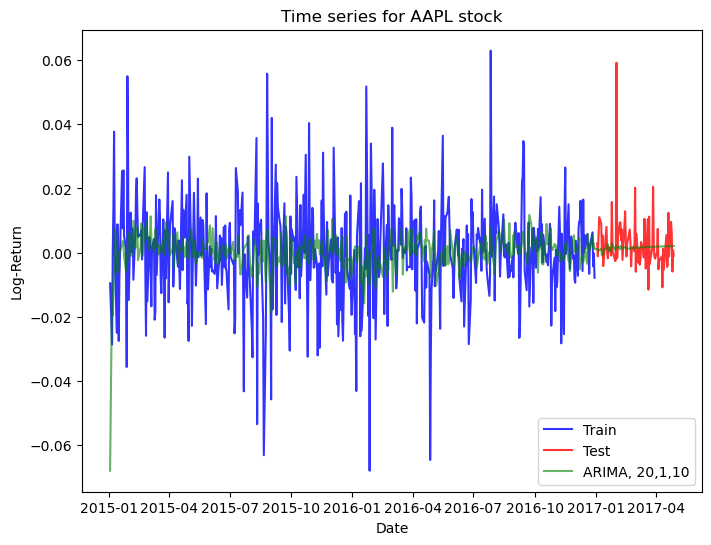

In [171]:
plt.plot(df_Apple_train['Date'],df_Apple_train['Log_Return'],alpha=0.8,color='blue',label='Train')
plt.plot(df_Apple_test['Date'],df_Apple_test['Log_Return'],alpha=0.8,color='red',label='Test')
plt.plot(df_ARIMA['Date'],df_ARIMA['Log_Return'],color='green',alpha=0.6,label='ARIMA, 20,1,10')
plt.xlabel('Date')
plt.ylabel('Log-Return')
plt.title('Time series for AAPL stock')
plt.legend()
plt.show()

Let us investigate MSE

In [172]:
predictions_y_ARIMA = model_fit2.predict(start=len(df_Apple_train['Log_Return']), end=len(df_Apple_train['Log_Return'])+len(df_Apple_test['Log_Return'])-1)

In [173]:
mse = tf.keras.losses.MeanSquaredError()

In [174]:
mse(scaled_array_test[:,0],predictions_y_ARIMA).numpy()

0.004566478481620249

In [175]:
mae = tf.keras.losses.MeanAbsoluteError()

In [176]:
mae(scaled_array_test[:,0],predictions_y_ARIMA).numpy()

0.04193271864088902

Did slightly better than Naive Forecasting!

Let us plot just the test date range

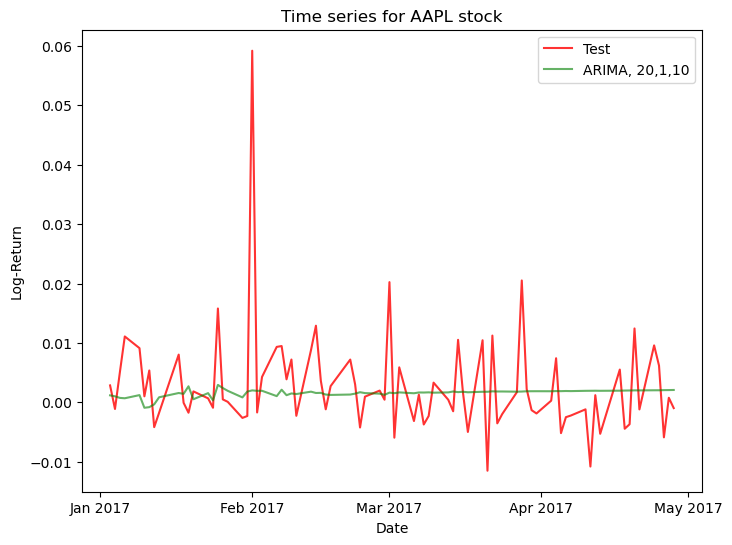

In [178]:
plt.plot(df_Apple_test['Date'],df_Apple_test['Log_Return'],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_test['Date'],scaler.inverse_transform(predictions_y_ARIMA.reshape(-1, 1))[:,0],color='green',alpha=0.6,label='ARIMA, 20,1,10')
plt.xlabel('Date')
plt.ylabel('Log-Return')
plt.title('Time series for AAPL stock')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
plt.show()

#### Prices ARIMA

In order to compare with the rolling window we will use for the RNN modeling, I am fixing p=40. Also, for a few experiments that I ran d=2 seemed to be mostly performing the best. For the next sprint, I plan to clean more the ARIMA section.

In [564]:
q_list=[20,25,30,35,40,45,50]
list_score=[]
for q in q_list:
    model2 = SARIMAX(scaled_array_train_p[:,0], order=(40, 2, q), trend="c")
    model_fit2 = model2.fit(disp=False)
    train_predictions2 = model_fit2.predict(start=0, end=len(df_Apple_train['Log_Return'])-1)
    test_predictions2 = model_fit2.predict(start=len(df_Apple_train['Log_Return']), end=len(df_Apple_train['Log_Return'])+len(df_Apple_test['Log_Return'])-1)
    # Calculate MSE for training data
    train_mse2 = mean_squared_error(scaled_array_train_p, train_predictions2)
    train_rmse2 = np.sqrt(train_mse2)

    # Calculate MSE for testing data
    test_mse2 = mean_squared_error(scaled_array_test_p, test_predictions2)
    test_rmse2 = np.sqrt(test_mse2)

    print(f"Train MSE: {train_mse2}, RMSE: {train_rmse2}")
    print(f"Test MSE: {test_mse2}, RMSE: {test_rmse2}")
    list_score.append(test_rmse2)

/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train MSE: 0.002314134990760807, RMSE: 0.04810545697486728
Test MSE: 0.2080371169699524, RMSE: 0.4561108603946549


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train MSE: 0.002306261349496632, RMSE: 0.04802354994683996
Test MSE: 0.22972586358172825, RMSE: 0.47929726014419094


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train MSE: 0.0023086604016323087, RMSE: 0.048048521326179316
Test MSE: 0.20203023821371474, RMSE: 0.44947773939730845


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train MSE: 0.002293287655772456, RMSE: 0.04788828307396765
Test MSE: 0.23775696929588605, RMSE: 0.48760329089936016


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train MSE: 0.0022848120495275927, RMSE: 0.04779970763014762
Test MSE: 0.2397487040003505, RMSE: 0.4896414034784543


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train MSE: 0.0022447852266072573, RMSE: 0.047379164477724355
Test MSE: 0.22649533112558146, RMSE: 0.4759152562437786


/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train MSE: 0.0022653660121792663, RMSE: 0.04759586129254587
Test MSE: 0.22325685584019983, RMSE: 0.47250064110030565


In [565]:
list_score

[0.4561108603946549,
 0.47929726014419094,
 0.44947773939730845,
 0.48760329089936016,
 0.4896414034784543,
 0.4759152562437786,
 0.47250064110030565]

p=40,d=2,q=30 seems to be doing a bit better!

Let us do the best model we found. We also use a seasonality trend of 'c', I plan to experiment with this parameter for the next Sprint.

In [566]:
p_param = 40 
d_param = 2
q_param = 30

model4 = SARIMAX(scaled_array_train_p[:,0], order=(p_param, d_param, q_param), trend="c")
model_fit4 = model4.fit(disp=0)

model_fit4.summary()

/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hmarrochiowork/opt/miniconda3/envs/tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  504
Model:             SARIMAX(40, 2, 30)   Log Likelihood                 870.650
Date:                Sun, 24 Nov 2024   AIC                          -1597.301
Time:                        15:53:51   BIC                          -1293.562
Sample:                             0   HQIC                         -1478.134
                                - 504                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -3.94e-05      0.001     -0.033      0.974      -0.002       0.002
ar.L1         -0.6634     15.778     -0.042      0.966     -31.588      30.262
ar.L2         -0.4496     24.079     -0.019      0.985     -47.644      46.745
ar.L3         -0.3761     24.627     -0.015      0.988     -48.644      47.892
ar.L4         -0.3083     21.861     -0.014      0.989     -43.155      42.539
ar.L5         -0.2017     15.653     -0.013      0.990     -30.881      30.478
ar.L6         -0.1961     10.443     -0.019      0.985     -20.664      20.272
ar.L7         -0.1499      7.126     -0.021      0.983     -14.116      13.816
ar.L8         -0.1476      6.636     -0.022      0.982     -13.155      12.859
ar.L9         -0.1182      6.227     -0.019      0.985     -12.324      12.087
ar.L10        -0.1758      6.973     -0.025      0.980     -13.843      13.492
ar.L11        -0.1469      8.556     -0.017      0.986     -16.916      16.622
ar.L12        -0.1546      9.821     -0.016      0.987     -19.402      19.093
ar.L13        -0.1252     10.344     -0.012      0.990     -20.398      20.148
ar.L14        -0.1310      9.336     -0.014      0.989     -18.429      18.167
ar.L15        -0.1629      7.349     -0.022      0.982     -14.567      14.241
ar.L16        -0.1389      6.226     -0.022      0.982     -12.342      12.064
ar.L17        -0.1305      5.279     -0.025      0.980     -10.477      10.216
ar.L18        -0.1320      4.120     -0.032      0.974      -8.207       7.943
ar.L19        -0.0738      3.079     -0.024      0.981      -6.109       5.961
ar.L20        -0.0669      2.290     -0.029      0.977      -4.555       4.421
ar.L21        -0.1214      2.169     -0.056      0.955      -4.373       4.131
ar.L22        -0.0898      3.310     -0.027      0.978      -6.577       6.397
ar.L23        -0.0419      4.134     -0.010      0.992      -8.145       8.061
ar.L24        -0.0646      3.780     -0.017      0.986      -7.473       7.344
ar.L25        -0.1100      3.288     -0.033      0.973      -6.555       6.335
ar.L26        -0.0404      3.337     -0.012      0.990      -6.581       6.500
ar.L27        -0.1127      2.904     -0.039      0.969      -5.804       5.579
ar.L28        -0.0983      2.918     -0.034      0.973      -5.817       5.620
ar.L29        -0.1066      2.894     -0.037      0.971      -5.779       5.565
ar.L30        -0.0900      2.481     -0.036      0.971      -4.953       4.773
ar.L31        -0.1145      2.545     -0.045      0.964      -5.103       4.874
ar.L32        -0.0039      2.869     -0.001      0.999      -5.627       5.619
ar.L33        -0.0046      2.267     -0.002      0.998      -4.448       4.439
ar.L34         0.0190      1.534      0.012      0.990      -2.988       3.026
ar.L35        -0.0754      1.569     -0.048      0.962      -3.150       2.999
ar.L36        -0.0023      1.273     -0.002      0.999      -2.497       2.493
ar.L37         0.0075      1.201      0.006      0.995      -2.346       2.361
ar

In [567]:
predictions4 = model_fit4.predict(start=0, end=len(df_Apple_train_p['Adj Close'])+len(df_Apple_test_p['Adj Close'])-1)

In [568]:
predictions_ARIMA_p_0 = scaler_p.inverse_transform(predictions4.reshape(-1, 1)) 

In [569]:
list_dates_p=df_Apple_train_p['Date'].tolist()+df_Apple_test_p['Date'].tolist()
df_ARIMA_p=pd.DataFrame({'Date':list_dates_p,'Adj Close':predictions_ARIMA_p_0[:,0]})

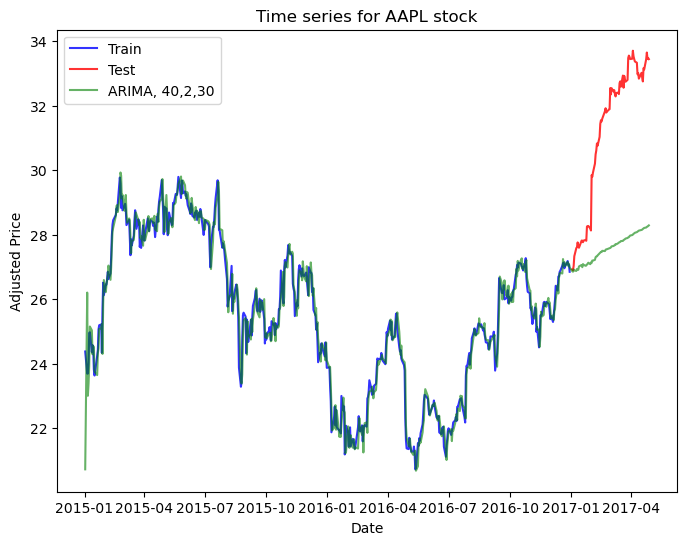

In [581]:
plt.plot(df_Apple_train_p['Date'],df_Apple_train_p['Adj Close'],alpha=0.8,color='blue',label='Train')
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],alpha=0.8,color='red',label='Test')
plt.plot(df_ARIMA_p['Date'],df_ARIMA_p['Adj Close'],color='green',alpha=0.6,label='ARIMA, 40,2,30')
plt.xlabel('Date')
plt.ylabel('Adjusted Price')
plt.title('Time series for AAPL stock')
plt.legend()
plt.savefig('figures/arima_price_all.png')
plt.show()

In [571]:
predictions_y_ARIMA_p = model_fit4.predict(start=len(df_Apple_train['Log_Return']), end=len(df_Apple_train['Log_Return'])+len(df_Apple_test['Log_Return'])-1)

In [572]:
mse(scaled_array_test_p[:,0],predictions_y_ARIMA_p).numpy()

0.20203023821371474

In [573]:
mae(scaled_array_test_p[:,0],predictions_y_ARIMA_p).numpy()

0.402670929182581

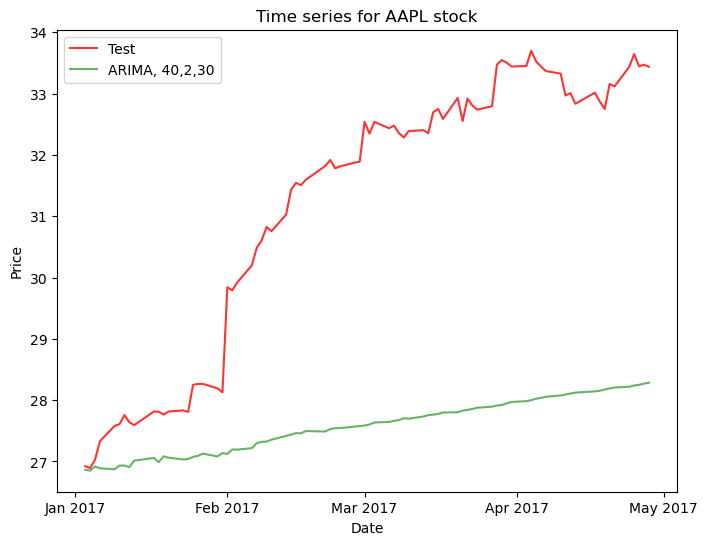

In [582]:
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_test_p['Date'],scaler_p.inverse_transform(predictions_y_ARIMA_p.reshape(-1, 1))[:,0],color='green',alpha=0.6,label='ARIMA, 40,2,30')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Time series for AAPL stock')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
plt.savefig('figures/arima_price_test.png')
plt.show()

## Part 10 - Recurrent Neural Networks

#### Log-Return

Let us now create train and test arrays that are labeled as features and prediction in order to train the RNN. I am choosing a window of 40 datapoints, but it might be worth experimenting with different windows.

In [503]:
X_train = []
y_train = []
for i in range(40, len(scaled_array_train)):
    X_train.append(scaled_array_train[i-40:i, 0])
    y_train.append(scaled_array_train[i, 0])

In [504]:
X_test = []
y_test = []
for i in range(40, len(scaled_array_test)):
    X_test.append(scaled_array_test[i-40:i, 0])
    y_test.append(scaled_array_test[i, 0])

In [505]:
# Transform from list to np.array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshape in order to feed into the RNN training
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print(f'X_train :{X_train.shape}, y_train :{y_train.shape}')

X_train :(464, 40, 1), y_train :(464, 1)


In [506]:
# Transform from list to np.array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshape in order to feed into the RNN training
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print(f'X_train :{X_test.shape}, y_train :{y_test.shape}')

X_train :(41, 40, 1), y_train :(41, 1)


Now let us run the RNN. As a note, I think it is worth investigatin better initialization of weights - even though I am using an adaptive optimizer with ADAM, for some runs the loss gets stuck in the same value. I tried adding `HeNormal` to the first layer in order to improve on this issue, but the MSE did not improve overall. I plan to investigate this initialization more in the future.

In [325]:
from tensorflow.keras.initializers import HeNormal

In [509]:
%%time
# initializing the RNN
regressor = Sequential()

# Here I am trying to add many layers and parameters, and adding just a very small dropout. For the price, I will try to attenuate overfitting.
regressor.add(SimpleRNN(units = 40, 
                        activation = "ReLU",
                        return_sequences = True,
                        #kernel_initializer=HeNormal(),
                        input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.05))

regressor.add(SimpleRNN(units = 40, 
                        activation = "ReLU",
                        return_sequences = True))

regressor.add(SimpleRNN(units = 40, 
                        activation = "ReLU",
                        return_sequences = True))

regressor.add(SimpleRNN(units = 40))

# Add the output layer
regressor.add(Dense(units = 1,activation='ReLU'))




regressor.compile(optimizer = Adam(learning_rate=0.0005), 
                 #loss="mean_absolute_percentage_error")
                  loss = "mean_squared_error")

# Fit the model we just constructed
regressor.fit(X_train, y_train, epochs = 100, batch_size = 2)
regressor.summary()

Epoch 1/100
232/232 [==============================] - 4s 16ms/step - loss: 0.0208
Epoch 2/100
232/232 [==============================] - 2s 7ms/step - loss: 0.0167
Epoch 3/100
232/232 [==============================] - 2s 7ms/step - loss: 0.0160
Epoch 4/100
232/232 [==============================] - 2s 8ms/step - loss: 0.0169
Epoch 5/100
232/232 [==============================] - 2s 7ms/step - loss: 0.0166
Epoch 6/100
232/232 [==============================] - 2s 7ms/step - loss: 0.0153
Epoch 7/100
232/232 [==============================] - 2s 7ms/step - loss: 0.0157
Epoch 8/100
232/232 [==============================] - 2s 7ms/step - loss: 0.0150
Epoch 9/100
232/232 [==============================] - 2s 7ms/step - loss: 0.0151
Epoch 10/100
232/232 [==============================] - 2s 7ms/step - loss: 0.0149
Epoch 11/100
232/232 [==============================] - 2s 7ms/step - loss: 0.0148
Epoch 12/100
232/232 [==============================] - 2s 7ms/step - loss: 0.0146
Epoch 13/100

In [510]:
y_RNN = regressor.predict(X_test)

2/2 [==============================] - 0s 9ms/step


In [511]:
y_RNN_O = scaler.inverse_transform(y_RNN) 

In [512]:
list_dates_RNN=df_Apple_test['Date'].iloc[40:].tolist()
df_try_RNN=pd.DataFrame({'Date':list_dates_RNN,'Log_Return':y_RNN_O[:,0]})

Let us show results, for now I am only plotting the part of the prediction where all the outputs are non-seen data (remember we need to feed 40 data points in order to forecast in this construction).

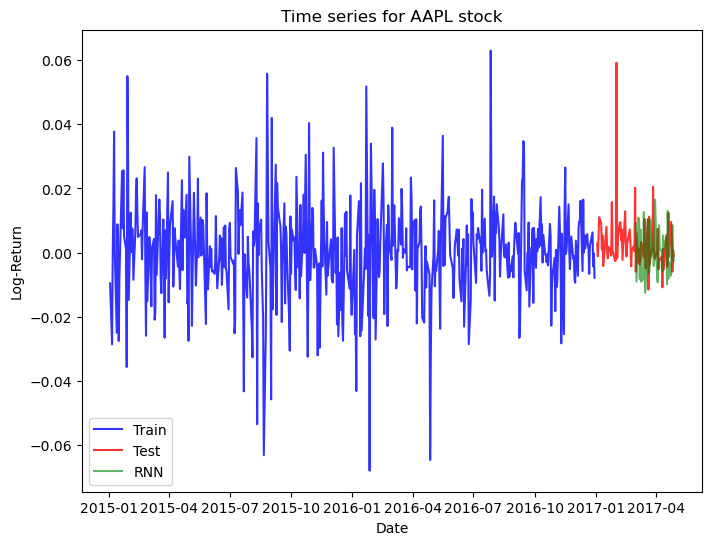

In [513]:
plt.plot(df_Apple_train['Date'],df_Apple_train['Log_Return'],alpha=0.8,color='blue',label='Train')
plt.plot(df_Apple_test['Date'],df_Apple_test['Log_Return'],alpha=0.8,color='red',label='Test')
plt.plot(df_try_RNN['Date'],df_try_RNN['Log_Return'],color='green',alpha=0.6,label='RNN')
plt.xlabel('Date')
plt.ylabel('Log-Return')
plt.title('Time series for AAPL stock')
plt.legend()
plt.show()

Let us actually use the full range of data (except the first 40 points) to forecast.

In [514]:
scaled_joined=np.concatenate((scaled_array_train, scaled_array_test), axis=0)

In [515]:
X_joined = []
for i in range(40, len(scaled_joined)):
    X_joined.append(scaled_joined[i-40:i, 0])

In [516]:
#List to array
X_joined = np.array(X_joined)

#Reshaping
X_joined = np.reshape(X_joined, (X_joined.shape[0], X_joined.shape[1],1))

In [517]:
y_joined_RNN = regressor.predict(X_joined)

18/18 [==============================] - 0s 6ms/step


In [518]:
y_joined_RNN_O = scaler.inverse_transform(y_joined_RNN) 

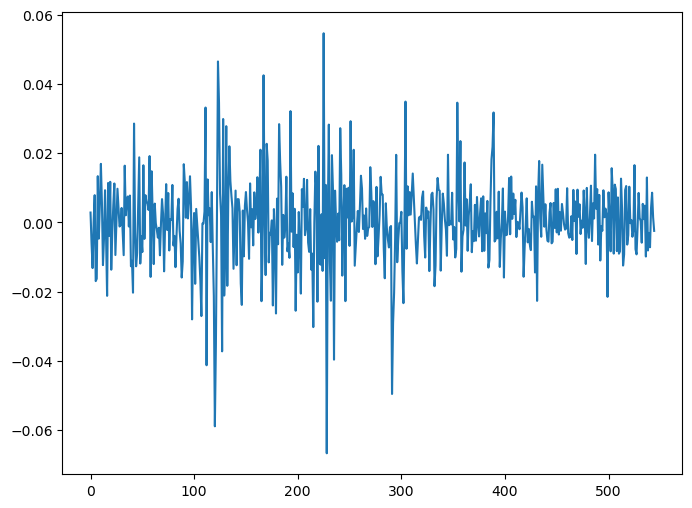

In [519]:
plt.plot(y_joined_RNN_O)

In [520]:
list_dates_joined_RNN=df_Apple_joined['Date'].iloc[40:].tolist()
df_joined_RNN=pd.DataFrame({'Date':list_dates_joined_RNN,'Log_Return':y_joined_RNN_O[:,0]})

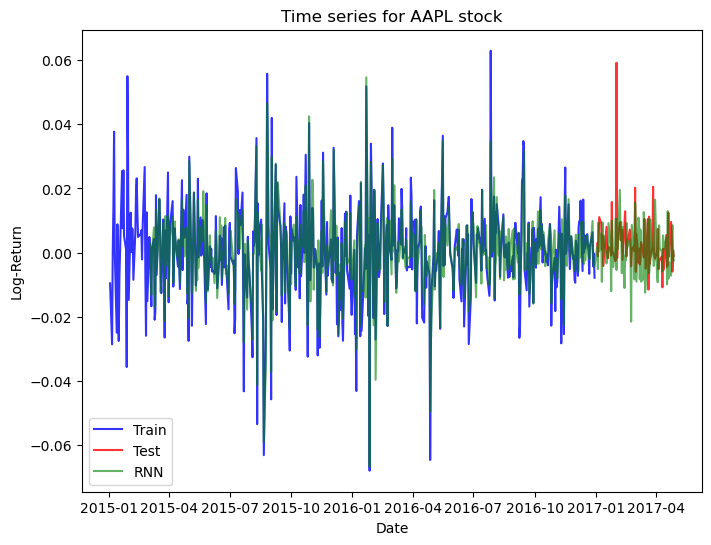

In [585]:
plt.plot(df_Apple_train['Date'],df_Apple_train['Log_Return'],alpha=0.8,color='blue',label='Train')
plt.plot(df_Apple_test['Date'],df_Apple_test['Log_Return'],alpha=0.8,color='red',label='Test')
plt.plot(df_joined_RNN['Date'],df_joined_RNN['Log_Return'],color='green',alpha=0.6,label='RNN')
plt.xlabel('Date')
plt.ylabel('Log-Return')
plt.title('Time series for AAPL stock')
plt.legend()
plt.savefig('figures/RNN_logreturn_all.png')
plt.show()

Let us calculate the MSE and MAE for the whole range of test data.

In [522]:
df_joined_scaled_RNN=pd.DataFrame({'Date':list_dates_joined_RNN,'Log_Return':y_joined_RNN[:,0]})

In [523]:
scaled_array_RNN_test=df_joined_scaled_RNN[df_joined_RNN['Date'].isin(df_Apple_test['Date'])]['Log_Return'].values

In [524]:
mse = tf.keras.losses.MeanSquaredError()

In [525]:
mse(scaled_array_test[:,0],scaled_array_RNN_test).numpy()

0.008543149

In [454]:
mae = tf.keras.losses.MeanAbsoluteError()

In [526]:
mae(scaled_array_test[:,0],scaled_array_RNN_test).numpy()

0.06556241

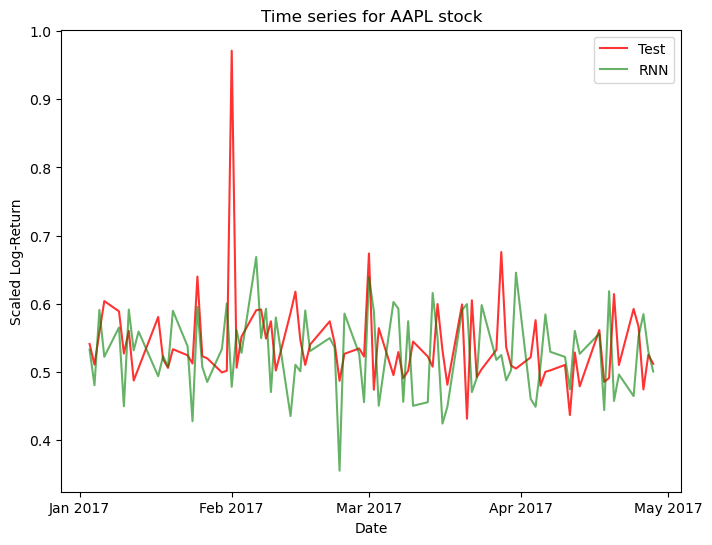

In [586]:
plt.plot(df_Apple_test['Date'],scaled_array_test[:,0],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_test['Date'],scaled_array_RNN_test,color='green',alpha=0.6,label='RNN')
plt.xlabel('Date')
plt.ylabel('Scaled Log-Return')
plt.title('Time series for AAPL stock')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
plt.savefig('figures/RNN_logreturn_test.png')
plt.show()

#### RNN - Prices

Similarly to the treatment of `Log_Return`, we have to create features and prediction in order to train the neural network, but using the data about prices themselves.

In [28]:
X_train_p = []
y_train_p = []
for i in range(40, len(scaled_array_train)):
    X_train_p.append(scaled_array_train_p[i-40:i, 0])
    y_train_p.append(scaled_array_train_p[i, 0])

In [29]:
X_test_p = []
y_test_p = []
for i in range(40, len(scaled_array_test)):
    X_test_p.append(scaled_array_test_p[i-40:i, 0])
    y_test_p.append(scaled_array_test_p[i, 0])

In [30]:
# Convert list into numpy array
X_train_p, y_train_p = np.array(X_train_p), np.array(y_train_p)

#Reshaping
X_train_p = np.reshape(X_train_p, (X_train_p.shape[0], X_train_p.shape[1],1))
y_train_p = np.reshape(y_train_p, (y_train_p.shape[0],1))
print("X_train :",X_train_p.shape,"y_train :",y_train_p.shape)

X_train : (464, 40, 1) y_train : (464, 1)


In [31]:
# Convert list into numpy array
X_test_p, y_test_p = np.array(X_test_p), np.array(y_test_p)

#Reshaping
X_test_p = np.reshape(X_test_p, (X_test_p.shape[0], X_test_p.shape[1],1))
y_test_p = np.reshape(y_test_p, (y_test_p.shape[0],1))
print("X_test :",X_test_p.shape,"y_test :",y_test_p.shape)

X_test : (41, 40, 1) y_test : (41, 1)


We can now train the RNN with the price data

For the prices analysis, I am actually trying to avoid overfitting, as I also want to forecast into the far future to benchmark how well the model is doing without using the past test data. 

In [106]:
# initializing the RNN
regressor_p = Sequential()

# Adding layers
regressor_p.add(SimpleRNN(units = 40, 
                        activation = "ReLU",
                        return_sequences = True,
                        input_shape = (X_train_p.shape[1],1)))
regressor_p.add(Dropout(0.2)) #Increase dropout rate to attenuate overfitting

# Start decreasing the size of hidden layers, gradual to avoid bottleneck of information.
regressor_p.add(SimpleRNN(units = 20, 
                        activation = "ReLU",
                        return_sequences = True))


regressor_p.add(SimpleRNN(units = 10))

#Output Layers
regressor_p.add(Dense(units = 1,activation='ReLU'))



regressor_p.compile(optimizer = Adam(learning_rate=0.0005), 
                  loss = "mean_squared_error")

# Fit the model
regressor_p.fit(X_train_p, y_train_p, epochs = 20, batch_size = 2)
regressor_p.summary()

Epoch 1/20
232/232 [==============================] - 2s 5ms/step - loss: 0.1938
Epoch 2/20
232/232 [==============================] - 1s 5ms/step - loss: 0.0117
Epoch 3/20
232/232 [==============================] - 1s 5ms/step - loss: 0.0071
Epoch 4/20
232/232 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 5/20
232/232 [==============================] - 1s 5ms/step - loss: 0.0051
Epoch 6/20
232/232 [==============================] - 1s 5ms/step - loss: 0.0047
Epoch 7/20
232/232 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 8/20
232/232 [==============================] - 1s 5ms/step - loss: 0.0044
Epoch 9/20
232/232 [==============================] - 1s 5ms/step - loss: 0.0042
Epoch 10/20
232/232 [==============================] - 1s 5ms/step - loss: 0.0038
Epoch 11/20
232/232 [==============================] - 1s 5ms/step - loss: 0.0036
Epoch 12/20
232/232 [==============================] - 1s 5ms/step - loss: 0.0035
Epoch 13/20
232/232 [====

In [107]:
scaled_joined_p=np.concatenate((scaled_array_train_p, scaled_array_test_p), axis=0)

In [108]:
X_joined_p = []
for i in range(40, len(scaled_joined_p)):
    X_joined_p.append(scaled_joined_p[i-40:i, 0])

In [109]:
# The data is converted to Numpy array
X_joined_p = np.array(X_joined_p)

#Reshaping
X_joined_p = np.reshape(X_joined_p, (X_joined_p.shape[0], X_joined_p.shape[1],1))

In [110]:
y_joined_RNN_p = regressor_p.predict(X_joined_p)

18/18 [==============================] - 0s 2ms/step


In [111]:
y_joined_RNN_p_O = scaler_p.inverse_transform(y_joined_RNN_p) 

In [112]:
list_dates_joined_RNN=df_Apple_joined['Date'].iloc[40:].tolist()
df_joined_RNN_p=pd.DataFrame({'Date':list_dates_joined_RNN,'Adj Close':y_joined_RNN_p_O[:,0]})

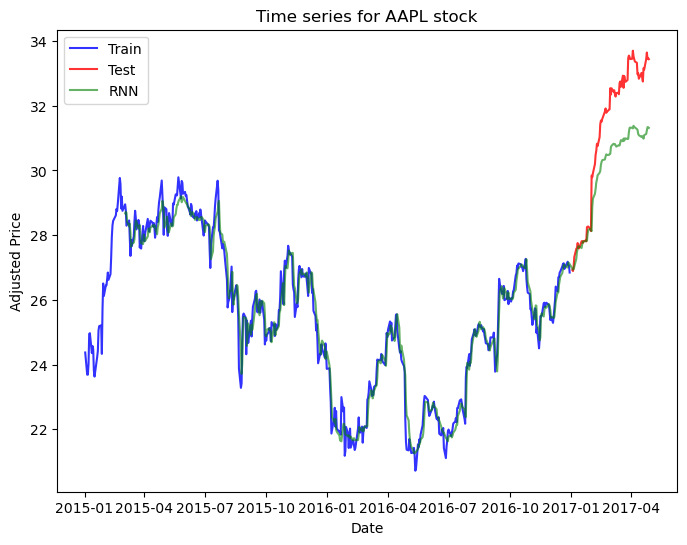

In [113]:
plt.plot(df_Apple_train_p['Date'],df_Apple_train_p['Adj Close'],alpha=0.8,color='blue',label='Train')
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],alpha=0.8,color='red',label='Test')
plt.plot(df_joined_RNN_p['Date'],df_joined_RNN_p['Adj Close'],color='green',alpha=0.6,label='RNN')
plt.xlabel('Date')
plt.ylabel('Adjusted Price')
plt.title('Time series for AAPL stock')
plt.legend()
plt.savefig('figures/RNN_price_all.png')
plt.show()

In [114]:
df_joined_RNN_scaled__p=pd.DataFrame({'Date':list_dates_joined_RNN,'Adj Close':y_joined_RNN_p[:,0]})

In [115]:
scaled_array_RNN_test_p=df_joined_RNN_scaled__p[df_joined_RNN_scaled__p['Date'].isin(df_Apple_test['Date'])]['Adj Close'].values

In [116]:
mse(scaled_array_test_p[:,0],scaled_array_RNN_test_p).numpy()

0.028507186

In [118]:
mae(scaled_array_test_p[:,0],scaled_array_RNN_test_p).numpy()

0.14534882

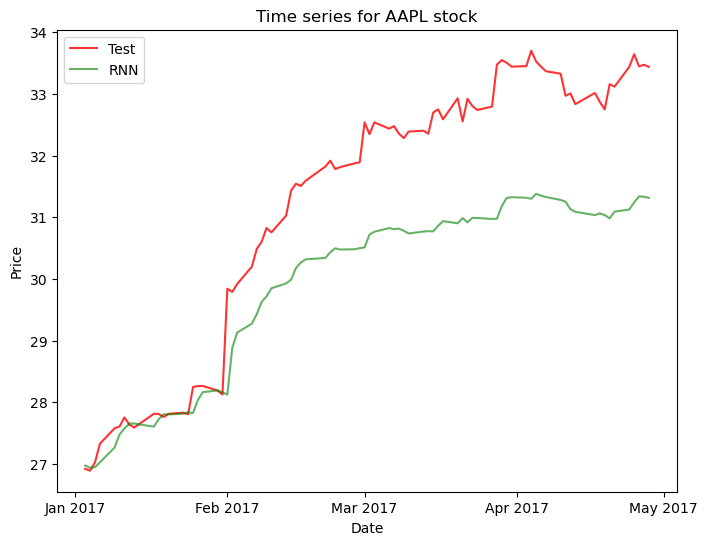

In [119]:
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_test_p['Date'],scaler_p.inverse_transform(scaled_array_RNN_test_p.reshape(-1, 1))[:,0],color='green',alpha=0.6,label='RNN')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Time series for AAPL stock')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
plt.savefig('figures/RNN_price_test.png')
plt.show()

### This result is very nice, but let us show what happens if we use only forecasted data to predict the future

If we only want to use training data, we need to define how many points we want to forecast (81) and how what is the window size we trained on

In [120]:
forecast_horizon = 81
window_size = 40

In [121]:
# Initialize the forecasted points array
forecasted_points = []

Let us remind ourselves of the rolling window shape

In [122]:
X_train_p.shape

(464, 40, 1)

So the current_window array needs to have a shape (1,40,1), starting with the last 40 points from training data

In [123]:
current_window = scaled_array_train_p[-window_size:].reshape(1, window_size, 1)

Now we do a loop, updating with the forecast with each step, until forecast_horizon is reached

In [124]:
for i in range(forecast_horizon):
    # Predict the next point using the trained RNN
    next_point = regressor_p.predict(current_window)[0, 0]; # The predicted value is an array, access the value
    
    # Append the forecasted point to the results
    forecasted_points.append(next_point)
    
    # Update the rolling window, the middle index starts from 1 instead of 0, update with next_point. [[[next_point]]] due to the tensor format.
    current_window = np.append(current_window[:, 1:, :], [[[next_point]]], axis=1)


1/1 [==============================] - 0s 9ms/step


In [125]:
forecasted_points = np.array(forecasted_points) #Tranform into np array

In [126]:
forecasted_points=forecasted_points.reshape(-1,1) #Reshape in order to fit the scaler transform

In [127]:
forecasted_points_0 = scaler_p.inverse_transform(forecasted_points) 

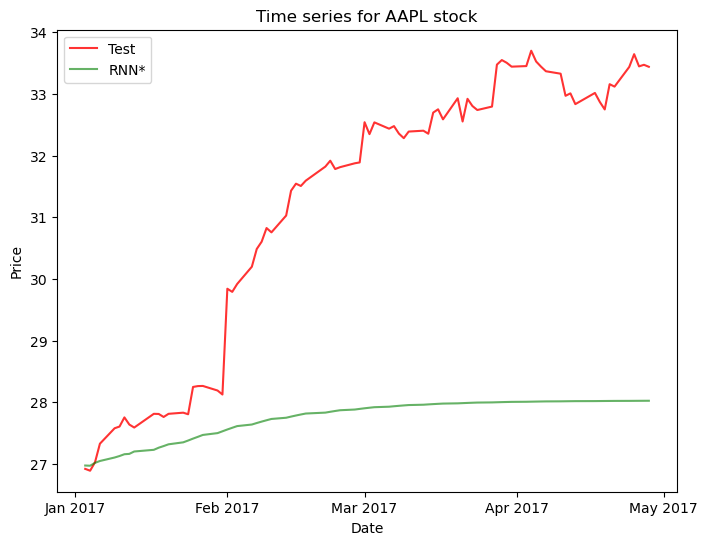

In [130]:
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_test_p['Date'],forecasted_points_0[:,0],color='green',alpha=0.6,label='RNN*')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Time series for AAPL stock')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
plt.savefig('figures/RNN_price_ONLY_test.png')
plt.show()

In [129]:
mse(scaled_array_test_p[:,0],forecasted_points).numpy()

0.20803893

We see that when we use our model to forecast into the future, with only using the results of the forecasting in order to predict further ahead, the results are similar to ARIMA. It is worth emphasizing that which model to use really depends on the context: If we can update the input every day, even without retraining the neural network we obtained a decent MSE. It makes sense though that whenever we stretch our prediction power for very far into the future, the model does not do as well. I plan to investigate more these nuances for the next Sprint. 

## Part 11 - Next Steps and Models

So far, under certain conditions, RNN seems to be a promising candidate in order to predict future price! However, the way we use our model makes all the difference: I am calling here __RNN*__ for a model where we __produce__ all the future forecast without access to the test data. Of course, if we are investigating historical data, it is still a useful exercise to only train the model with training data, but use the testing data up to a given day to produce the next one. I plan to explore these subletities more for my next Sprint. Similarly, I want to investigate ARIMA using the rolling window framework we used for the RNN. 


| Model       |  Parameters           | MSE        |
|:-----------:|:---------------------:|:----------:| 
| Naive Avg   | Training Data Average |    0.356   |  
| ARIMA       |       (40,2,30)       |   0.202    |
| RNN*        | ReLU, avoid overfitting |   0.208  |



In addition, the plan is to explore other RNN architectures such asLSTM, GRU and Transformer. Therefore, my plan is to fill this table as my next few steps.


| Model       |  Learning Rate (ADAM) | Activation | MSE        |
|:-----------:|:---------------------:|:----------:|:----------:|   
| RNN         |            0.005      |     'ReLU' |    0.028   |
| GRU         |                       |            |            |
| LSTM        |                       |            |            |
| Transformer |                       |            |            |

## Appendix A - Naive Forecasting - Access to Data Every Day in the Test Set

### 9.1 Baseline - Simple Naive Forecasting

#### Log-Return Naive Forecasting

In this appendix, I want to perform a different type of naive forecasting, where we simply cast the previous day data to the next one.

In [65]:
df_Apple_joined['Naive_Forecast']=df_Apple_joined['Log_Return'].shift(1)

In [49]:
#df_Apple_joined.dropna(inplace=True)

Let us cast the naive forecast to a separate dataframe

In [66]:
df_Apple_NaiveForecast=df_Apple_joined[['Date','Naive_Forecast']]

Drop the null value due to the lag

In [67]:
df_Apple_NaiveForecast.dropna(inplace=True)

/var/folders/qr/7jt362956klf0dnc_163b7nw0000gp/T/ipykernel_66814/2724955479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Apple_NaiveForecast.dropna(inplace=True)


Let us do the scaling in order to compare the mean squared errors to the other methods we will employ

In [93]:
array_naive = df_Apple_NaiveForecast['Naive_Forecast'].values 
array_naive = np.reshape(array_naive, (-1,1)) 
scaled_array_naive = scaler.transform(array_naive)

In [94]:
df_Apple_NaiveForecast['Scaled_Naive_Forecast']=scaled_array_naive

/var/folders/qr/7jt362956klf0dnc_163b7nw0000gp/T/ipykernel_66814/1245522756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Apple_NaiveForecast['Scaled_Naive_Forecast']=scaled_array_naive


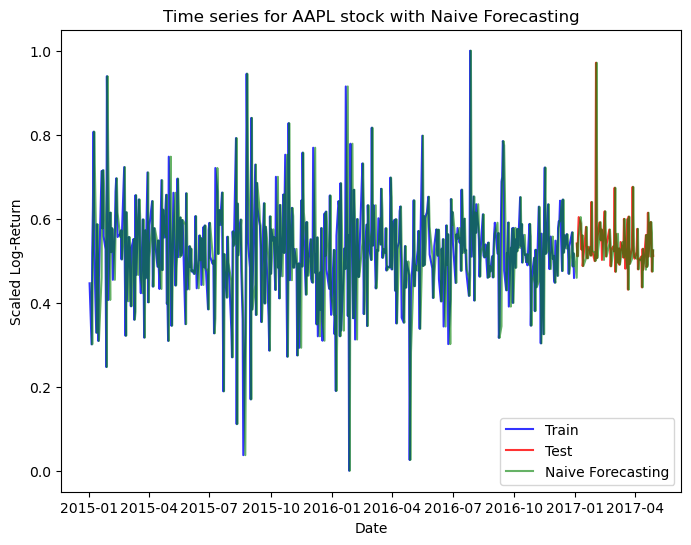

In [101]:
plt.plot(df_Apple_train['Date'],scaled_array_train[:,0],alpha=0.8,color='blue',label='Train')
plt.plot(df_Apple_test['Date'],scaled_array_test[:,0],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_NaiveForecast['Date'],df_Apple_NaiveForecast['Scaled_Naive_Forecast'],color='green',alpha=0.6,label='Naive Forecasting')
plt.xlabel('Date')
plt.ylabel('Scaled Log-Return')
plt.title('Time series for AAPL stock with Naive Forecasting')
plt.legend()
plt.show()

Let us look into the two losses

In [86]:
mse = tf.keras.losses.MeanSquaredError()

In [98]:
mse(scaled_array_test[:,0],df_Apple_NaiveForecast[df_Apple_NaiveForecast['Date'].isin(df_Apple_test['Date'])]['Scaled_Naive_Forecast'].values).numpy()

0.010431235256850887

In [90]:
mae = tf.keras.losses.MeanAbsoluteError()

In [99]:
mae(scaled_array_test[:,0],df_Apple_NaiveForecast[df_Apple_NaiveForecast['Date'].isin(df_Apple_test['Date'])]['Scaled_Naive_Forecast'].values).numpy()

0.0660669706104712

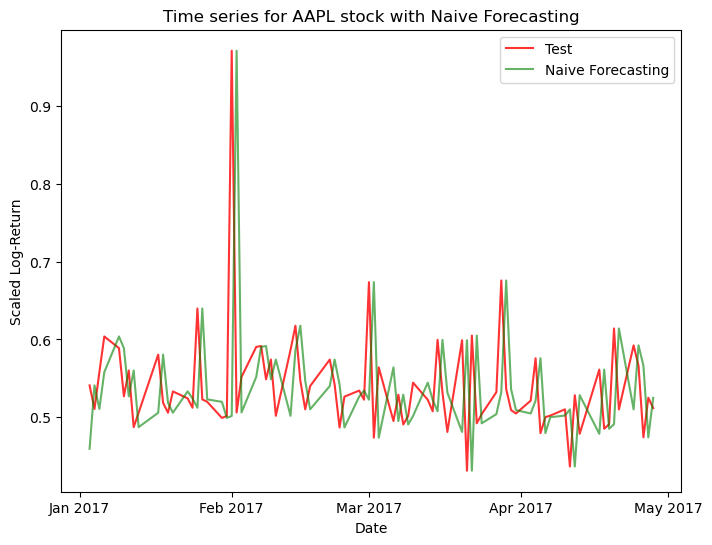

In [113]:
plt.plot(df_Apple_test['Date'],scaled_array_test[:,0],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_test['Date'],df_Apple_NaiveForecast[df_Apple_NaiveForecast['Date'].isin(df_Apple_test['Date'])]['Scaled_Naive_Forecast'].values,color='green',alpha=0.6,label='Naive Forecasting')
plt.xlabel('Date')
plt.ylabel('Scaled Log-Return')
plt.title('Time series for AAPL stock with Naive Forecasting')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.show()

#### Price Naive Forecasting

In [116]:
df_Apple_joined_p['Naive_Forecast']=df_Apple_joined_p['Adj Close'].shift(1)

Let us cast the naive forecast to a separate dataframe

In [117]:
df_Apple_NaiveForecast_p=df_Apple_joined_p[['Date','Naive_Forecast']]

Drop the null value due to the lag

In [118]:
df_Apple_NaiveForecast_p.dropna(inplace=True)

/var/folders/qr/7jt362956klf0dnc_163b7nw0000gp/T/ipykernel_66814/2783462049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Apple_NaiveForecast_p.dropna(inplace=True)


Let us do the scaling in order to compare the mean squared errors to the other methods we will employ

In [120]:
array_naive_p = df_Apple_NaiveForecast_p['Naive_Forecast'].values 
array_naive_p = np.reshape(array_naive_p, (-1,1)) 
scaled_array_naive_p = scaler_p.transform(array_naive_p)

In [121]:
df_Apple_NaiveForecast_p['Scaled_Naive_Forecast']=scaled_array_naive_p

/var/folders/qr/7jt362956klf0dnc_163b7nw0000gp/T/ipykernel_66814/3621300307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Apple_NaiveForecast_p['Scaled_Naive_Forecast']=scaled_array_naive_p


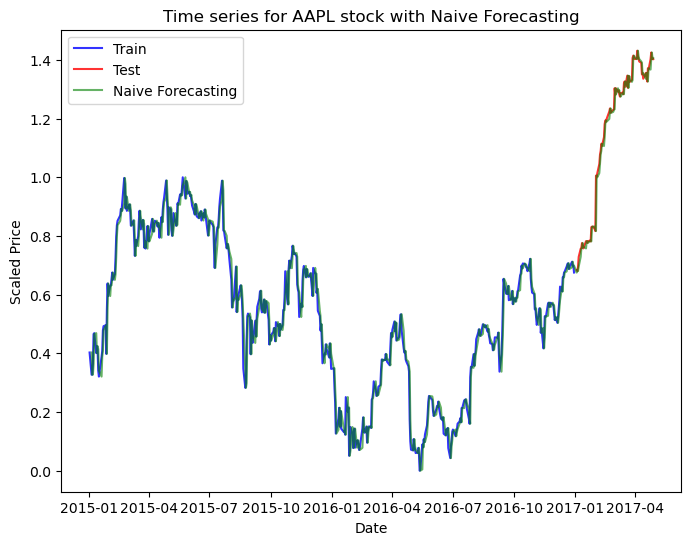

In [123]:
plt.plot(df_Apple_train['Date'],scaled_array_train_p[:,0],alpha=0.8,color='blue',label='Train')
plt.plot(df_Apple_test['Date'],scaled_array_test_p[:,0],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_NaiveForecast_p['Date'],df_Apple_NaiveForecast_p['Scaled_Naive_Forecast'],color='green',alpha=0.6,label='Naive Forecasting')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.title('Time series for AAPL stock with Naive Forecasting')
plt.legend()
plt.show()

Let us look into the two losses

In [130]:
scaled_array_naiveforecast_test_p=df_Apple_NaiveForecast_p[df_Apple_NaiveForecast_p['Date'].isin(df_Apple_test_p['Date'])]['Scaled_Naive_Forecast'].values

In [86]:
mse = tf.keras.losses.MeanSquaredError()

In [135]:
mse(scaled_array_test_p[:,0],scaled_array_naiveforecast_test_p).numpy()

0.0009431793546785362

In [90]:
mae = tf.keras.losses.MeanAbsoluteError()

In [134]:
mae(scaled_array_test_p[:,0],scaled_array_naiveforecast_test_p).numpy()

0.018548973089220707

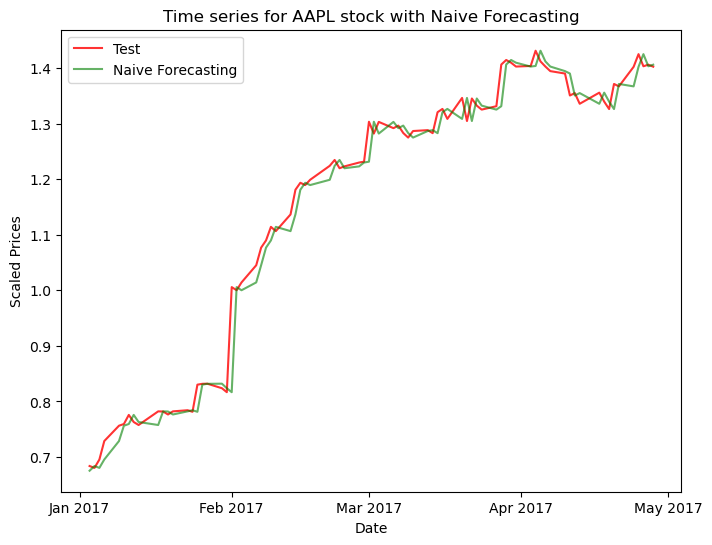

In [133]:
plt.plot(df_Apple_test['Date'],scaled_array_test_p[:,0],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_test['Date'],scaled_array_naiveforecast_test_p,color='green',alpha=0.6,label='Naive Forecasting')
plt.xlabel('Date')
plt.ylabel('Scaled Prices')
plt.title('Time series for AAPL stock with Naive Forecasting')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.show()

Honestly surprisingly good mse! Of course this is not as useful if all the information we have is the training data, and we want to focus on long term strategies, but nonetheless it is a useful exercise to show how depending on the nature of the problem, naive forecasting can be quite effective!